In [6]:
# 导入必要的库
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# 设置中文显示支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载
print("正在加载heart_disease.csv文件...")
try:
    # 读取CSV文件
    data = pd.read_csv('heart_disease.csv')
    print("数据加载成功！数据形状:", data.shape)
    print("\n数据前5行:")
    display(data.head())

    # 2. 数据预处理
    print("\n正在进行数据预处理...")
    print("\n" + "="*50)
    print("描述性统计分析")
    print("="*50)

    # 数值型变量描述性统计
    desc_stats = data.describe()
    print(desc_stats)


    # 连续变量离散化
    data['Age'] = pd.cut(data['Age'], bins=[0, 30, 50, 70, 100],
                         labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
    data['Blood Pressure'] = pd.cut(data['Blood Pressure'], bins=[0, 120, 140, 200],
                                    labels=['Normal', 'Elevated', 'High'])
    data['Cholesterol Level'] = pd.cut(data['Cholesterol Level'], bins=[0, 200, 240, 500],
                                       labels=['Normal', 'Borderline', 'High'])
    data['BMI'] = pd.cut(data['BMI'], bins=[0, 18.5, 25, 30, 100],
                         labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    data['Sleep Hours'] = pd.cut(data['Sleep Hours'], bins=[0, 6, 8, 24],
                                 labels=['Insufficient', 'Normal', 'Excessive'])
    data['Triglyceride Level'] = pd.cut(data['Triglyceride Level'], bins=[0, 150, 200, 500],
                                        labels=['Normal', 'Borderline', 'High'])
    data['Fasting Blood Sugar'] = pd.cut(data['Fasting Blood Sugar'], bins=[0, 100, 126, 300],
                                       labels=['Normal', 'Prediabetes', 'Diabetes'])
    data['CRP Level'] = pd.cut(data['CRP Level'], bins=[0, 3, 10, 100],
                               labels=['Low', 'Moderate', 'High'])
    data['Homocysteine Level'] = pd.cut(data['Homocysteine Level'], bins=[0, 12, 15, 100],
                                        labels=['Normal', 'Borderline', 'High'])

    # 准备事务数据
    print("\n准备事务数据")
    excluded_cols = ['Heart Disease Status']  
    transactions = []
    for i in range(len(data)):
        transaction = []
        for col in data.columns:
            if col not in excluded_cols:  
                transaction.append(f"{col}={data[col].iloc[i]}")
        transactions.append(transaction)

    # 转换为one-hot编码
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # 3. 挖掘频繁项集函数
    def mine_all_frequent_itemsets(method='apriori', min_support=0.2):
        if method == 'apriori':
            freq_itemsets = apriori(df, min_support=min_support, use_colnames=True)
        else:
            freq_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

        freq_itemsets_display = freq_itemsets.copy()
        freq_itemsets_display['length'] = freq_itemsets_display['itemsets'].apply(lambda x: len(x))
        max_length = freq_itemsets_display['length'].max()

        for k in range(1, max_length+1):
            k_itemsets = freq_itemsets_display[freq_itemsets_display['length'] == k]
            print(f"\n{k}-项集数量: {len(k_itemsets)}")
            if len(k_itemsets) > 0:
                display(k_itemsets.sort_values('support', ascending=False).head(10))

        return freq_itemsets, freq_itemsets_display

    # 4. Apriori 挖掘
    print("\n" + "="*50)
    print("使用Apriori算法挖掘频繁项集")
    print("="*50)
    frequent_itemsets_ap, frequent_itemsets_ap_display = mine_all_frequent_itemsets(method='apriori', min_support=0.2)

    # 5. FP-Growth 挖掘
    print("\n" + "="*50)
    print("使用FP-Growth算法挖掘频繁项集")
    print("="*50)
    frequent_itemsets_fp, frequent_itemsets_fp_display = mine_all_frequent_itemsets(method='fpgrowth', min_support=0.2)

    # 6. 关联规则函数
    def generate_all_rules(frequent_itemsets, min_confidence=0.6):
        if not frequent_itemsets.empty:
            try:
                rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
                print(f"\n生成的关联规则数量: {len(rules)}")
                if len(rules) > 0:
                    display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
                          .sort_values(['confidence', 'lift'], ascending=False).head(20))
                return rules
            except Exception as e:
                print(f"\n生成关联规则时出错: {str(e)}")
                return pd.DataFrame()
        else:
            print("\n没有频繁项集，无法生成关联规则")
            return pd.DataFrame()

    # 生成基于Apriori的规则
    print("\n基于Apriori的关联规则:")
    rules_ap = generate_all_rules(frequent_itemsets_ap, min_confidence=0.6)

    # 生成基于FP-Growth的规则
    print("\n基于FP-Growth的关联规则:")
    rules_fp = generate_all_rules(frequent_itemsets_fp, min_confidence=0.6)

    print("\n分析完成！")

except FileNotFoundError:
    print("\n错误：未找到heart_disease.csv文件，请确保该文件存在于当前目录中")
except Exception as e:
    print("\n发生错误:", str(e))

正在加载heart_disease.csv文件...
数据加载成功！数据形状: (10000, 21)

数据前5行:


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No



正在进行数据预处理...

描述性统计分析
               Age  Blood Pressure  Cholesterol Level          BMI  \
count  9971.000000     9981.000000        9970.000000  9978.000000   
mean     49.296259      149.757740         225.425577    29.077269   
std      18.193970       17.572969          43.575809     6.307098   
min      18.000000      120.000000         150.000000    18.002837   
25%      34.000000      134.000000         187.000000    23.658075   
50%      49.000000      150.000000         226.000000    29.079492   
75%      65.000000      165.000000         263.000000    34.520015   
max      80.000000      180.000000         300.000000    39.996954   

       Sleep Hours  Triglyceride Level  Fasting Blood Sugar    CRP Level  \
count  9975.000000         9974.000000          9978.000000  9974.000000   
mean      6.991329          250.734409           120.142213     7.472201   
std       1.753195           87.067226            23.584011     4.340248   
min       4.000605          100.000000    

,support,itemsets,length
49,0.6623,(Triglyceride Level=High),1
10,0.6462,(Blood Pressure=High),1
42,0.5123,(Smoking=Yes),1
31,0.5036,(High LDL Cholesterol=No),1
30,0.5022,(High Blood Pressure=Yes),1
17,0.5018,(Diabetes=No),1
22,0.5004,(Family Heart Disease=No),1
28,0.5003,(Gender=Male),1
37,0.5000,(Low HDL Cholesterol=Yes),1
27,0.4978,(Gender=Female),1



2-项集数量: 227


,support,itemsets,length
107,0.4278,"(Triglyceride Level=High, Blood Pressure=High)",2
270,0.3387,"(Triglyceride Level=High, Smoking=Yes)",2
225,0.3365,"(Triglyceride Level=High, Gender=Male)",2
265,0.3350,"(Low HDL Cholesterol=Yes, Triglyceride Level=H...",2
247,0.3348,"(Triglyceride Level=High, High LDL Cholesterol...",2
148,0.3334,"(Triglyceride Level=High, Diabetes=No)",2
179,0.3307,"(Triglyceride Level=High, Family Heart Disease...",2
241,0.3306,"(Triglyceride Level=High, High Blood Pressure=...",2
192,0.3301,"(Triglyceride Level=High, Family Heart Disease...",2
233,0.3300,"(Triglyceride Level=High, High Blood Pressure=No)",2



3-项集数量: 16


,support,itemsets,length
286,0.2187,"(Triglyceride Level=High, Blood Pressure=High,...",3
292,0.2163,"(Triglyceride Level=High, Blood Pressure=High,...",3
290,0.2152,"(Low HDL Cholesterol=Yes, Triglyceride Level=H...",3
283,0.2149,"(Triglyceride Level=High, Gender=Male, Blood P...",3
281,0.2146,"(Triglyceride Level=High, Family Heart Disease...",3
285,0.2142,"(Triglyceride Level=High, High Blood Pressure=...",3
278,0.2135,"(Triglyceride Level=High, Blood Pressure=High,...",3
279,0.2132,"(Triglyceride Level=High, Blood Pressure=High,...",3
284,0.2123,"(Triglyceride Level=High, Blood Pressure=High,...",3
280,0.2122,"(Triglyceride Level=High, Family Heart Disease...",3



使用FP-Growth算法挖掘频繁项集

1-项集数量: 50


,support,itemsets,length
0,0.6623,(Triglyceride Level=High),1
1,0.6462,(Blood Pressure=High),1
2,0.5123,(Smoking=Yes),1
3,0.5036,(High LDL Cholesterol=No),1
4,0.5022,(High Blood Pressure=Yes),1
5,0.5018,(Diabetes=No),1
31,0.5004,(Family Heart Disease=No),1
6,0.5003,(Gender=Male),1
7,0.5000,(Low HDL Cholesterol=Yes),1
19,0.4978,(Gender=Female),1



2-项集数量: 227


,support,itemsets,length
50,0.4278,"(Triglyceride Level=High, Blood Pressure=High)",2
51,0.3387,"(Triglyceride Level=High, Smoking=Yes)",2
69,0.3365,"(Triglyceride Level=High, Gender=Male)",2
77,0.3350,"(Low HDL Cholesterol=Yes, Triglyceride Level=H...",2
54,0.3348,"(Triglyceride Level=High, High LDL Cholesterol...",2
63,0.3334,"(Triglyceride Level=High, Diabetes=No)",2
208,0.3307,"(Triglyceride Level=High, Family Heart Disease...",2
58,0.3306,"(Triglyceride Level=High, High Blood Pressure=...",2
86,0.3301,"(Triglyceride Level=High, Family Heart Disease...",2
124,0.3300,"(Triglyceride Level=High, High Blood Pressure=No)",2



3-项集数量: 16


,support,itemsets,length
57,0.2187,"(Triglyceride Level=High, Blood Pressure=High,...",3
53,0.2163,"(Triglyceride Level=High, Blood Pressure=High,...",3
85,0.2152,"(Low HDL Cholesterol=Yes, Triglyceride Level=H...",3
76,0.2149,"(Triglyceride Level=High, Gender=Male, Blood P...",3
95,0.2146,"(Triglyceride Level=High, Family Heart Disease...",3
62,0.2142,"(Triglyceride Level=High, High Blood Pressure=...",3
68,0.2135,"(Triglyceride Level=High, Blood Pressure=High,...",3
143,0.2132,"(Triglyceride Level=High, Blood Pressure=High,...",3
130,0.2123,"(Triglyceride Level=High, Blood Pressure=High,...",3
118,0.2122,"(Triglyceride Level=High, Gender=Female, Blood...",3



基于Apriori的关联规则:

生成的关联规则数量: 109


,antecedents,consequents,support,confidence,lift
78,"(BMI=Obese, Blood Pressure=High)",(Triglyceride Level=High),0.2027,0.682492,1.030487
57,(Gender=Male),(Triglyceride Level=High),0.3365,0.672596,1.015546
74,(Sugar Consumption=High),(Triglyceride Level=High),0.2235,0.671171,1.013394
104,"(Low HDL Cholesterol=Yes, Blood Pressure=High)",(Triglyceride Level=High),0.2152,0.670196,1.011922
65,(Low HDL Cholesterol=Yes),(Triglyceride Level=High),0.3350,0.670000,1.011626
96,"(High LDL Cholesterol=No, Blood Pressure=High)",(Triglyceride Level=High),0.2187,0.669217,1.010443
76,(Sugar Consumption=Medium),(Triglyceride Level=High),0.2174,0.668923,1.010000
68,(Sleep Hours=Normal),(Triglyceride Level=High),0.2181,0.668403,1.009215
86,"(Family Heart Disease=Yes, Blood Pressure=High)",(Triglyceride Level=High),0.2146,0.667081,1.007219
5,(BMI=Obese),(Triglyceride Level=High),0.3054,0.666958,1.007033



基于FP-Growth的关联规则:

生成的关联规则数量: 109


,antecedents,consequents,support,confidence,lift
104,"(BMI=Obese, Blood Pressure=High)",(Triglyceride Level=High),0.2027,0.682492,1.030487
18,(Gender=Male),(Triglyceride Level=High),0.3365,0.672596,1.015546
99,(Sugar Consumption=High),(Triglyceride Level=High),0.2235,0.671171,1.013394
25,"(Low HDL Cholesterol=Yes, Blood Pressure=High)",(Triglyceride Level=High),0.2152,0.670196,1.011922
22,(Low HDL Cholesterol=Yes),(Triglyceride Level=High),0.3350,0.670000,1.011626
9,"(High LDL Cholesterol=No, Blood Pressure=High)",(Triglyceride Level=High),0.2187,0.669217,1.010443
40,(Sugar Consumption=Medium),(Triglyceride Level=High),0.2174,0.668923,1.010000
38,(Sleep Hours=Normal),(Triglyceride Level=High),0.2181,0.668403,1.009215
29,"(Family Heart Disease=Yes, Blood Pressure=High)",(Triglyceride Level=High),0.2146,0.667081,1.007219
101,(BMI=Obese),(Triglyceride Level=High),0.3054,0.666958,1.007033



分析完成！



基础数据分析

性别分布:
Gender
Male      5003
Female    4978
Name: count, dtype: int64

心脏病状态分布:
Heart Disease Status
No     8000
Yes    2000
Name: count, dtype: int64


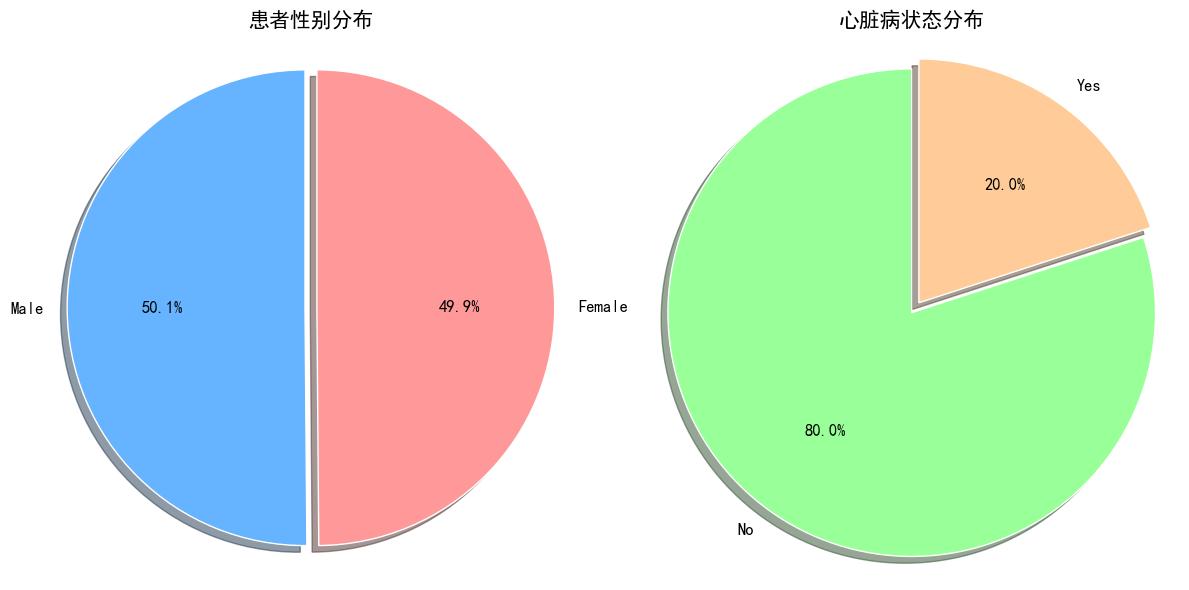

In [49]:
# 基础数据分析
print("\n" + "="*50)
print("基础数据分析")
print("="*50)

#  性别分布分析
gender_dist = data['Gender'].value_counts()
print("\n性别分布:")
print(gender_dist)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
plt.pie(gender_dist, 
        labels=gender_dist.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff','#ff9999'],
        explode=(0.05, 0),
        shadow=True,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 12})
plt.title('患者性别分布', fontsize=15)
plt.axis('equal')

# 心脏病状态分析（
heart_disease_dist = data['Heart Disease Status'].value_counts()
print("\n心脏病状态分布:")
print(heart_disease_dist)

plt.subplot(1, 2, 2)  
plt.pie(heart_disease_dist, 
        labels=heart_disease_dist.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=['#99ff99','#ffcc99'],
        explode=(0.05, 0),
        shadow=True,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 12})
plt.title('心脏病状态分布', fontsize=15)
plt.axis('equal')

plt.tight_layout()  
plt.show()


结果可视化


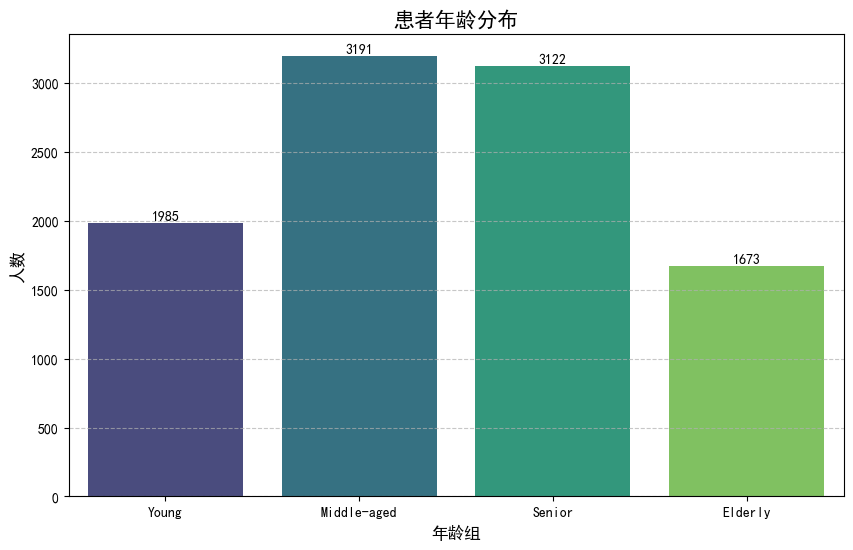

In [50]:
# 结果可视化
print("\n" + "="*50)
print("结果可视化")
print("="*50)

# 年龄分布条形图（
plt.figure(figsize=(10, 6))
age_order = ['Young', 'Middle-aged', 'Senior', 'Elderly']
sns.countplot(x='Age', data=data, order=age_order, 
              hue='Age', palette='viridis', legend=False)  
plt.title('患者年龄分布', fontsize=15)
plt.xlabel('年龄组', fontsize=12)
plt.ylabel('人数', fontsize=12)
# 在柱子上方显示具体数值
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', 
                      xytext=(0, 5), 
                      textcoords='offset points',
                      fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()